# Parte 2 - Simulando falhas na rede

In [1]:
%%capture
!pip install networkx
!pip install matplotlib
!pip install seaborn

In [2]:
import numpy as np
import networkx as nx
import pandas as pd
import random as rd
import copy
import numpy.random as nprd
import seaborn as sns

from utils.log import Log

In [3]:
from utils.mcmc import *

In [4]:
def gera_grafo_circular(n_vertices, n_arestas):
    grafo = np.zeros((n_vertices, n_vertices))

    for vertice in range(n_vertices):
        proximo = (vertice + 1) % n_vertices
        if proximo > vertice:
            grafo[proximo, vertice] = 1
        else:
            grafo[vertice, proximo] = 1

    arestas_restantes = n_arestas - n_vertices
        
    # Cria lista de arestas ainda não existentes
    possiveis = list()
    for i in range(n_vertices):
        for j in range(i):
            if grafo[i,j] == 0:
                possiveis.append((i,j))
    
    # Escolhe arestas aleatorias não existentes para criar
    for aresta in rd.sample(possiveis, arestas_restantes):
        grafo[aresta] = 1

    return grafo

In [5]:
def draw(grafo):
    nx.draw_circular(nx.Graph(grafo), with_labels=True)

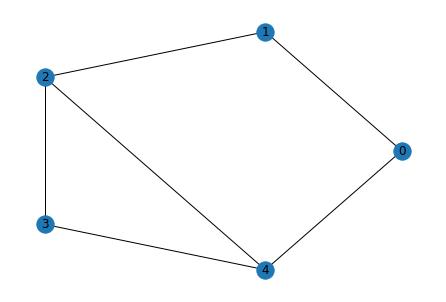

In [6]:
grafo = gera_grafo_circular(5,6)
draw(grafo)

In [7]:
class Simulacao:
    def __init__(self, grafo_base, tempo_max, log, tx_falha, tx_conserto):
        self.log = log
        self.tempo_max = tempo_max

        self.grafo_base = grafo_base
        self.tx_falha = tx_falha
        self.tx_conserto = tx_conserto
        
    def adiciona_evento(self, evento):
        self.fila_eventos.append( evento )
        self.fila_eventos.sort(key=lambda x : x[2], reverse=True)
    
    def recupera_evento(self):
        return self.fila_eventos.pop()
    
    def fila_esta_vazia(self):
        return len(self.fila_eventos) == 0

    def esta_desconectado(self, grafo):
        tmp = np.where(grafo==-1, 0, grafo)
        G = nx.Graph(tmp)
        return not nx.is_connected(G)

    def tem_link_desligado(self, grafo):
        i, _ = np.where(grafo == -1)
        return len(i) > 0

    def conectado_e_link_falho(self, grafo):
        tmp = np.where(grafo==-1, 0, grafo)
        G = nx.Graph(tmp)
        return self.tem_link_desligado(grafo) and nx.is_connected(G)
    
    def falha(self, aresta):
        raise Exception("Evento de Falha não implementado.")

    def conserto(self, aresta):
        raise Exception("Evento de Conserto não implementado.")

    def inicializa(self):
        self.fila_eventos = []
        self.estado_atual = copy.deepcopy(self.grafo_base)
        
        self.tempo_total = 0
        self.tempo_desconectado = 0
        self.tempo_sem_link = 0
        self.tempo_conectado_sem_link = 0

        arestas = nx.Graph(self.grafo_base).edges
        for j, i in arestas:
            evento = ((i,j), self.falha, nprd.exponential(self.tx_falha))
            self.adiciona_evento(evento)
            #self.log.info("[?] Falha agendada: {} em {}".format(evento[0], evento[2]))

    def simula(self):
        self.inicializa()

        while self.tempo_total < self.tempo_max:
            if self.fila_esta_vazia():
                self.log("Fila Vazia. Fim.")
                break

            aresta, evento, tempo = self.recupera_evento()

            delta = tempo - self.tempo_total
            self.tempo_desconectado          += delta * self.esta_desconectado(self.estado_atual)
            self.tempo_conectado_sem_link    += delta * self.conectado_e_link_falho(self.estado_atual)
            self.tempo_sem_link              += delta * self.tem_link_desligado(self.estado_atual)

            self.tempo_total = tempo

            evento(aresta)
            
        
        #self.log.info("-------------------------")
        #self.log.info("TEMPO TOTAL: {}".format(self.tempo_total))
        #self.log.info("TEMPO DESCONECTADO: {}".format(self.tempo_desconectado))
        #self.log.info("TEMPO SEM LINK: {}".format(self.tempo_sem_link))
        #self.log.info("TEMPO CONECTADO SEM LINK: {}".format(self.tempo_conectado_sem_link))
        #self.log.save()

        return self.tempo_desconectado/self.tempo_total, \
            self.tempo_sem_link/self.tempo_total, \
            self.tempo_conectado_sem_link/self.tempo_total

## Estocástico

### Cenário 1 - Falhas e consertos paralelos

In [8]:
class SimulacaoCenario1(Simulacao):

    def falha(self, aresta):
        self.estado_atual[aresta] = -1
        #self.log.info("[!] {} -> FALHA em {}".format(self.tempo_total, aresta))

        tempo = self.tempo_total + nprd.exponential(self.tx_conserto)
        proximo_conserto = (aresta, self.conserto, tempo)
        self.adiciona_evento(proximo_conserto)
        #self.log.info("[?] Conserto agendado em {}".format(proximo_conserto[2]))

    def conserto(self, aresta):
        self.estado_atual[aresta] = 1
        #self.log.info("[!] {} -> CONSERTO em {}".format(self.tempo_total, aresta))

        tempo = self.tempo_total + nprd.exponential(self.tx_falha)
        proxima_falha = (aresta, self.falha, tempo)
        self.adiciona_evento(proxima_falha)
        #self.log.info("[?] Falha agendada em {}".format(proxima_falha[2]))
        

In [9]:
sim_cenario1 = SimulacaoCenario1(grafo, 10, Log("simulacao_falhas_1"), 1, 1)
desconectado, sem_link, conectado_sem_link = sim_cenario1.simula()

print("Desconectado:", desconectado)
print("Sem Link:", sem_link)
print("Conectado sem link:", conectado_sem_link)

Desconectado: 0.8115009595375938
Sem Link: 0.9927115059852846
Conectado sem link: 0.18121054644769058


### Cenário 2 - Falhas paralelas e consertos sequenciais

In [10]:
class SimulacaoCenario2(Simulacao):

    def inicializa(self):
        self.fila_conserto = []
        
        super().inicializa()
    
    def falha(self, aresta):
        self.estado_atual[aresta] = -1
        #self.log.info("[!] {} -> FALHA em {}".format(self.tempo_total, aresta))

        if len(self.fila_conserto) == 0:
            proximo_conserto = (None, self.conserto, self.tempo_total + nprd.exponential(self.tx_conserto))
            self.adiciona_evento(proximo_conserto)
            #self.log.info("[?] Conserto agendado em {} (primeiro da fila)".format(proximo_conserto[2]))

        self.fila_conserto.insert(0, aresta)
        #self.log.info("Falha inserida na fila")

    def conserto(self, aresta):
        aresta = self.fila_conserto.pop()

        self.estado_atual[aresta] = 1
        #self.log.info("[!] {} -> CONSERTO em {}".format(self.tempo_total, aresta))

        proxima_falha = (aresta, self.falha, self.tempo_total + nprd.exponential(self.tx_falha))
        self.adiciona_evento(proxima_falha)
        #self.log.info("[?] Falha agendada em {}".format(proxima_falha[2]))

        if len(self.fila_conserto) > 0:
            proximo_conserto = (None, self.conserto, self.tempo_total + nprd.exponential(self.tx_conserto))
            self.adiciona_evento(proximo_conserto)
            #self.log.info("[?] Conserto agendado em {} (encadeado)".format(proximo_conserto[2]))

In [11]:
sim_cenario2 = SimulacaoCenario2(grafo, 20, Log("simulacao_falhas_1"), 1, 1)
desconectado, sem_link, conectado_sem_link = sim_cenario2.simula()

print("Desconectado:", desconectado)
print("Sem Link:", sem_link)
print("Conectado sem link:", conectado_sem_link)

Desconectado: 0.9490567248481766
Sem Link: 0.976908243824743
Conectado sem link: 0.02785151897656636


## Determinístico

In [12]:
class SimulacaoCenario1Deterministico(Simulacao):

    def falha(self, aresta):
        self.estado_atual[aresta] = -1
        #self.log.info("[!] {} -> FALHA em {}".format(self.tempo_total, aresta))

        tempo = self.tempo_total + self.tx_conserto
        proximo_conserto = (aresta, self.conserto, tempo)
        self.adiciona_evento(proximo_conserto)
        #self.log.info("[?] Conserto agendado em {}".format(proximo_conserto[2]))

    def conserto(self, aresta):
        self.estado_atual[aresta] = 1
        #self.log.info("[!] {} -> CONSERTO em {}".format(self.tempo_total, aresta))

        tempo = self.tempo_total + nprd.exponential(self.tx_falha)
        proxima_falha = (aresta, self.falha, tempo)
        self.adiciona_evento(proxima_falha)
        #self.log.info("[?] Falha agendada em {}".format(proxima_falha[2]))
        

In [13]:
class SimulacaoCenario2Deterministico(Simulacao):

    def inicializa(self):
        self.fila_conserto = []
        
        super().inicializa()
    
    def falha(self, aresta):
        self.estado_atual[aresta] = -1
        #self.log.info("[!] {} -> FALHA em {}".format(self.tempo_total, aresta))

        if len(self.fila_conserto) == 0:
            proximo_conserto = (None, self.conserto, self.tempo_total + self.tx_conserto)
            self.adiciona_evento(proximo_conserto)
            #self.log.info("[?] Conserto agendado em {} (primeiro da fila)".format(proximo_conserto[2]))

        self.fila_conserto.insert(0, aresta)
        #self.log.info("Falha inserida na fila")

    def conserto(self, aresta):
        aresta = self.fila_conserto.pop()

        self.estado_atual[aresta] = 1
        #self.log.info("[!] {} -> CONSERTO em {}".format(self.tempo_total, aresta))

        proxima_falha = (aresta, self.falha, self.tempo_total + nprd.exponential(self.tx_falha))
        self.adiciona_evento(proxima_falha)
        #self.log.info("[?] Falha agendada em {}".format(proxima_falha[2]))

        if len(self.fila_conserto) > 0:
            proximo_conserto = (None, self.conserto, self.tempo_total + self.tx_conserto)
            self.adiciona_evento(proximo_conserto)
            #self.log.info("[?] Conserto agendado em {} (encadeado)".format(proximo_conserto[2]))

## Calcular Intervalo de Confiança

In [42]:
rodadas = 100
execucoes = 10
tempo_max = 40

entradas = [(5,6), (5,7), (16,20), (20,25), (28,31), (29,30)]
cenarios = []

for entrada in entradas:
    _, grafo, _, _ = criador_grafo_mcmc(n_vertices=entrada[0], n_arestas=entrada[1], iteracoes=500)
    for simulador in [SimulacaoCenario1Deterministico, SimulacaoCenario2Deterministico, SimulacaoCenario1, SimulacaoCenario2]:
        cenarios.append(
            (entrada, simulador.__name__, simulador(grafo_base=grafo, tempo_max=tempo_max, log=None, tx_conserto=1, tx_falha=1))
        )

In [43]:
from tqdm.notebook import tqdm

resultados = pd.DataFrame()

for entrada, cenario_cod, simulador in cenarios:
    for rodada_indice in range(rodadas):
        for iteracao in range(execucoes):
            desconectado, sem_link, conectado_sem_link = simulador.simula()

            linha = {
                'entrada': entrada,
                'cenario': cenario_cod,
                'rodada': rodada_indice,
                'tempo_desconectado': desconectado,
                'tempo_conectado_sem_link': conectado_sem_link,
                'tempo_sem_link': sem_link
            }

            resultados = resultados.append(linha, ignore_index=True)

resultados.to_csv("results/simulacoes.csv", header=True)

In [44]:
resultados_por_round = resultados.groupby(by=['entrada','cenario','rodada']).mean().reset_index()
resultados_por_round

,entrada,cenario,rodada,tempo_desconectado,tempo_conectado_sem_link,tempo_sem_link
0,"(5, 6)",SimulacaoCenario1,0.0,0.723328,0.262731,0.986058
1,"(5, 6)",SimulacaoCenario1,1.0,0.724452,0.253547,0.977999
2,"(5, 6)",SimulacaoCenario1,2.0,0.699962,0.276496,0.976459
3,"(5, 6)",SimulacaoCenario1,3.0,0.713811,0.269374,0.983186
4,"(5, 6)",SimulacaoCenario1,4.0,0.724763,0.255507,0.980271
...,...,...,...,...,...,...
2395,"(29, 30)",SimulacaoCenario2Deterministico,95.0,0.997415,0.002221,0.999637
2396,"(29, 30)",SimulacaoCenario2Deterministico,96.0,0.997631,0.001394,0.999024
2397,"(29, 30)",SimulacaoCenario2Deterministico,97.0,0.997483,0.001690,0.999173
2398,"(29, 30)",SimulacaoCenario2Deterministico,98.0,0.997912,0.001579,0.999491


### Avaliando Resultados

In [45]:
import math

def confidence_interval(quantity, mean, variance, z=1.96):
    # Calcula o intervalo de confiança de uma amostra
    
    std_dev = math.sqrt(variance)
    return np.float(mean - z*(std_dev/math.sqrt(quantity))), np.float(mean + z*(std_dev/math.sqrt(quantity)))

In [106]:
import statistics as stats
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime

from matplotlib import rcParams
rcParams['figure.subplot.top'] = 0.9
rcParams['axes.labelpad'] = 10
rcParams['axes.ymargin'] = 0.9


def salva_figura(titulo, resultados, cenario, n_vertices, n_arestas):
    fig, ax = plt.subplots(nrows=3, ncols=2)
    fig.set_size_inches((12,12))

    txt_cenario = ['Estocástico', 'Determinístico']
    txt_reward = ['Tempo Sem Link', 'Tempo Desconectado', 'Tempo Conectado Sem Link']


    for i, valor in enumerate(['tempo_sem_link', 'tempo_desconectado', 'tempo_conectado_sem_link']):
        for j, tipo in enumerate([f'SimulacaoCenario{cenario}', f'SimulacaoCenario{cenario}Deterministico']):
            valores = resultados[(resultados.cenario==tipo)][valor]

            ic_min, ic_max = confidence_interval(len(valores), stats.mean(valores),stats.variance(valores))

            sns.distplot(valores, bins=10, fit=norm, kde=False, ax=ax[i,j])

            ax[i,j].set_title(f'{txt_reward[i]}\n{txt_cenario[j]}\nIC95=({round(ic_min,3)},{round(ic_max,3)})')
            ax[i,j].set_xlabel("Proporção de Tempo")

    fig.suptitle(f'{titulo} - ({n_vertices} vértices e {n_arestas} arestas)', fontsize=20)
    fig.tight_layout(pad=3.0)

    titulo_tmp = titulo.lower().replace("-","").replace(" ","_").replace("/","-")
    plt.savefig(f'imgs/sim_{n_vertices}_{n_arestas}_{titulo_tmp}.png')
    plt.show()


C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(mean - z*(std_dev/math.sqrt(quantity))), np.float(mean + z*(std_dev/math.sqrt(quantity)))
C:\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprec

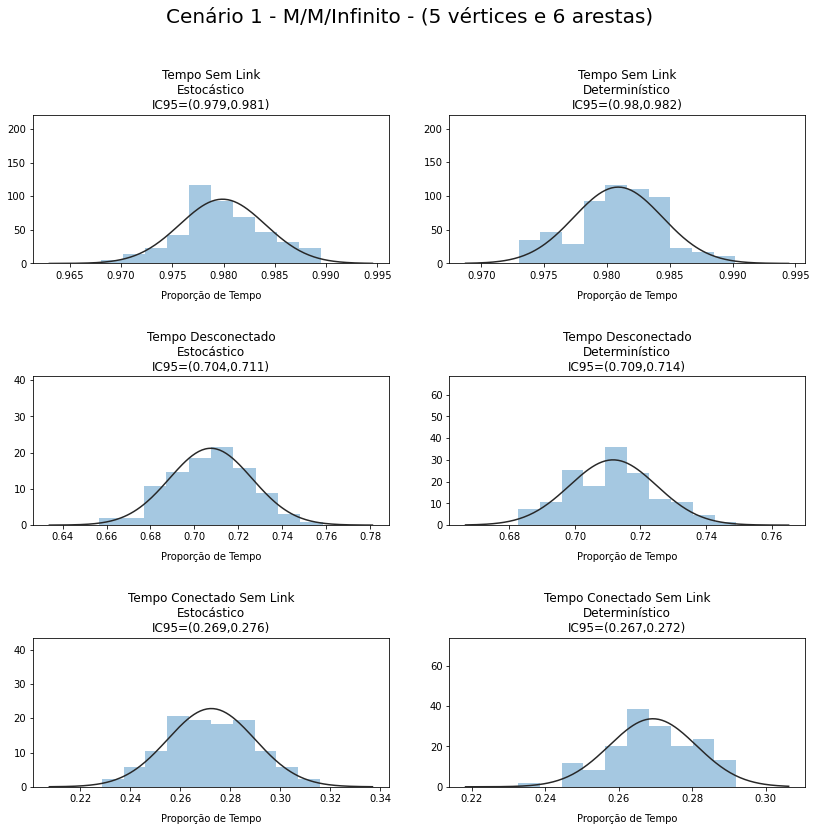

C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(mean - z*(std_dev/math.sqrt(quantity))), np.float(mean + z*(std_dev/math.sqrt(quantity)))
C:\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprec

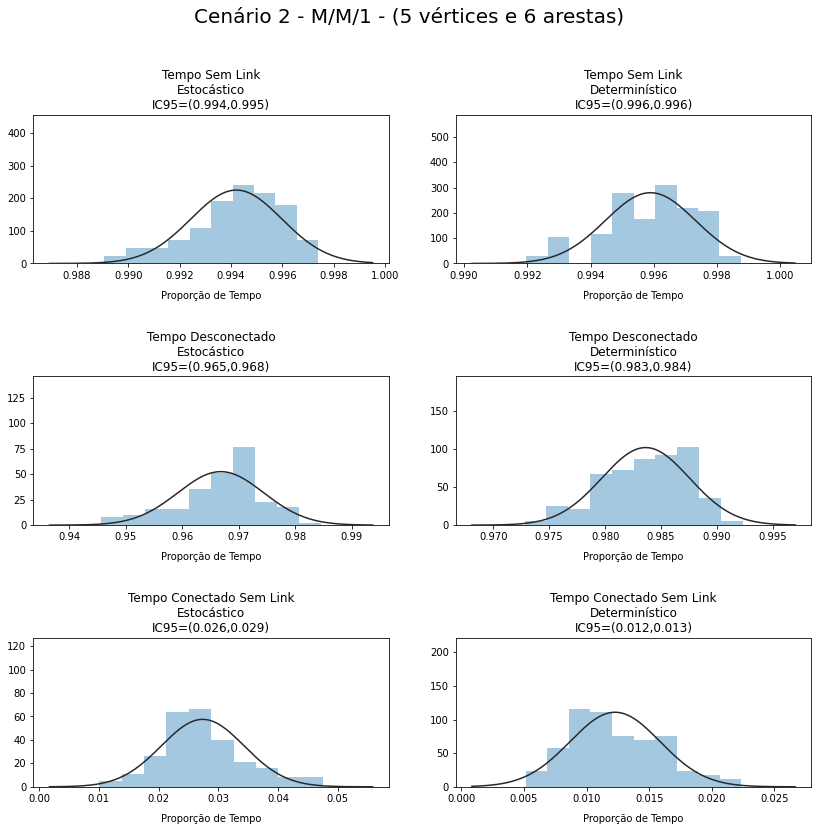

C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(mean - z*(std_dev/math.sqrt(quantity))), np.float(mean + z*(std_dev/math.sqrt(quantity)))
C:\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprec

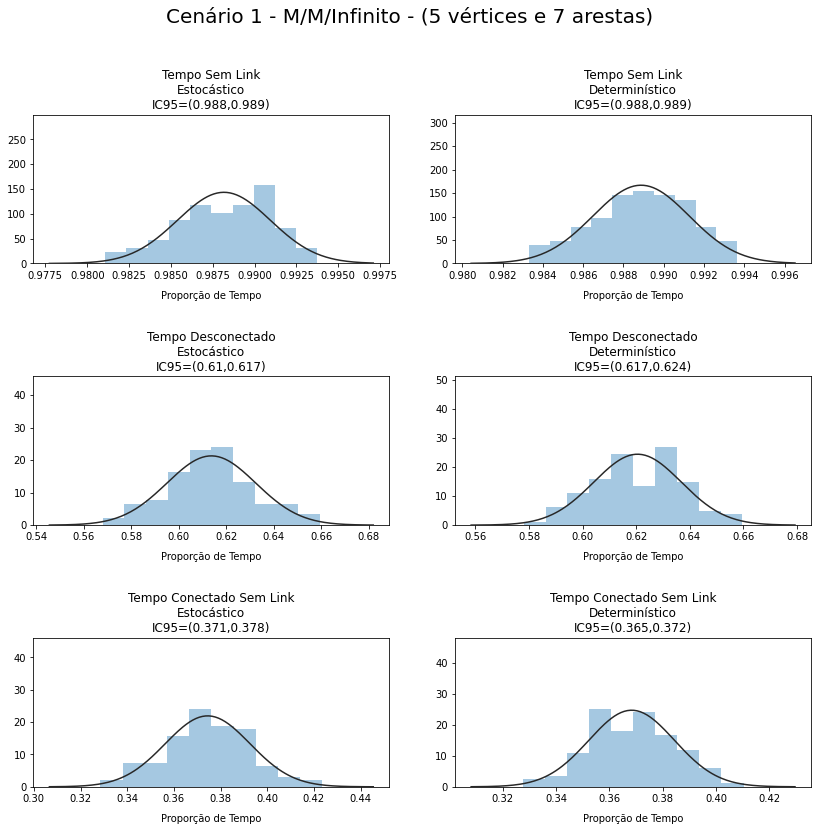

C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(mean - z*(std_dev/math.sqrt(quantity))), np.float(mean + z*(std_dev/math.sqrt(quantity)))
C:\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprec

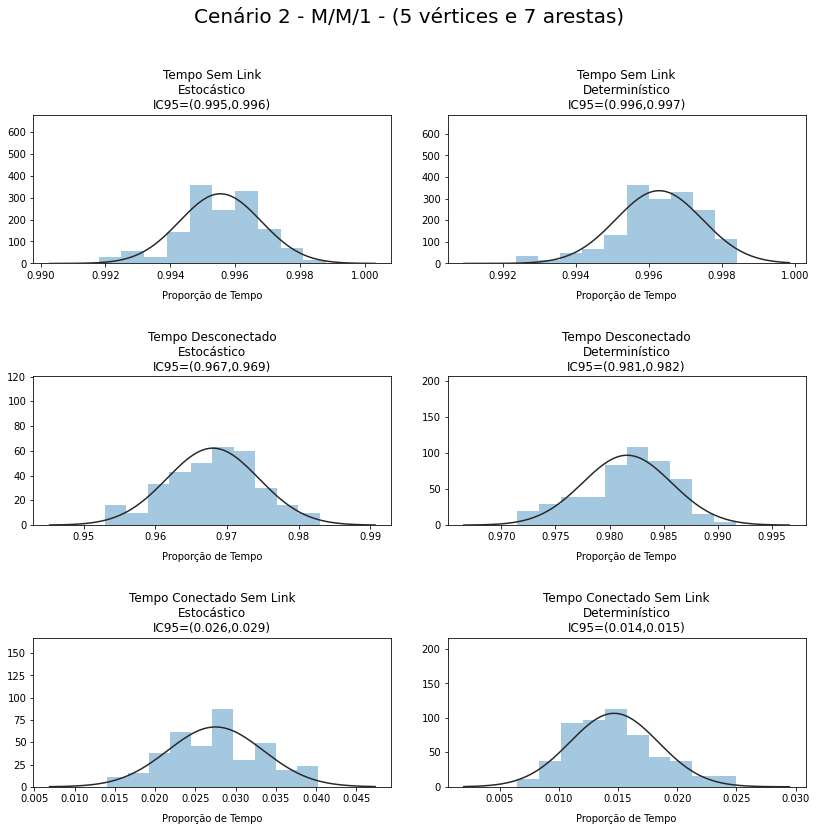

C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(mean - z*(std_dev/math.sqrt(quantity))), np.float(mean + z*(std_dev/math.sqrt(quantity)))
C:\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprec

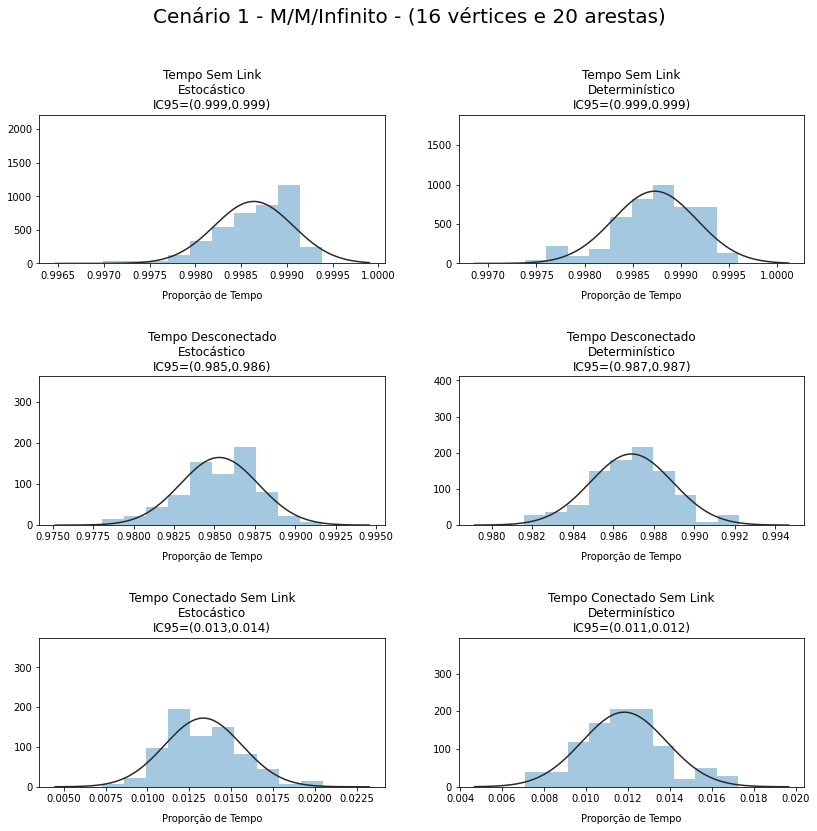

C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(mean - z*(std_dev/math.sqrt(quantity))), np.float(mean + z*(std_dev/math.sqrt(quantity)))
C:\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprec

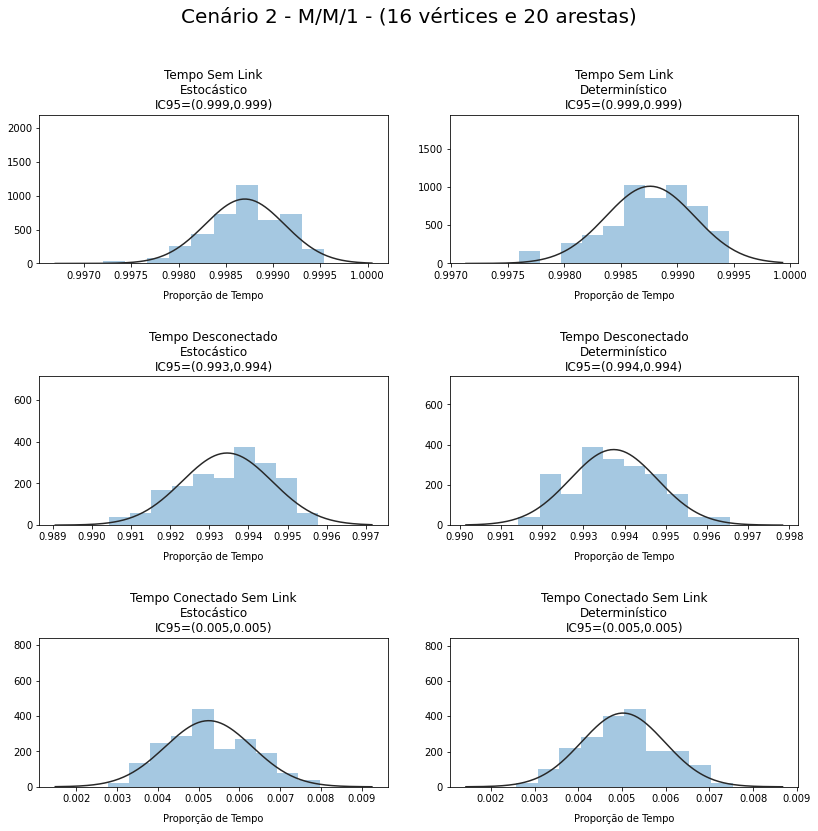

C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(mean - z*(std_dev/math.sqrt(quantity))), np.float(mean + z*(std_dev/math.sqrt(quantity)))
C:\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprec

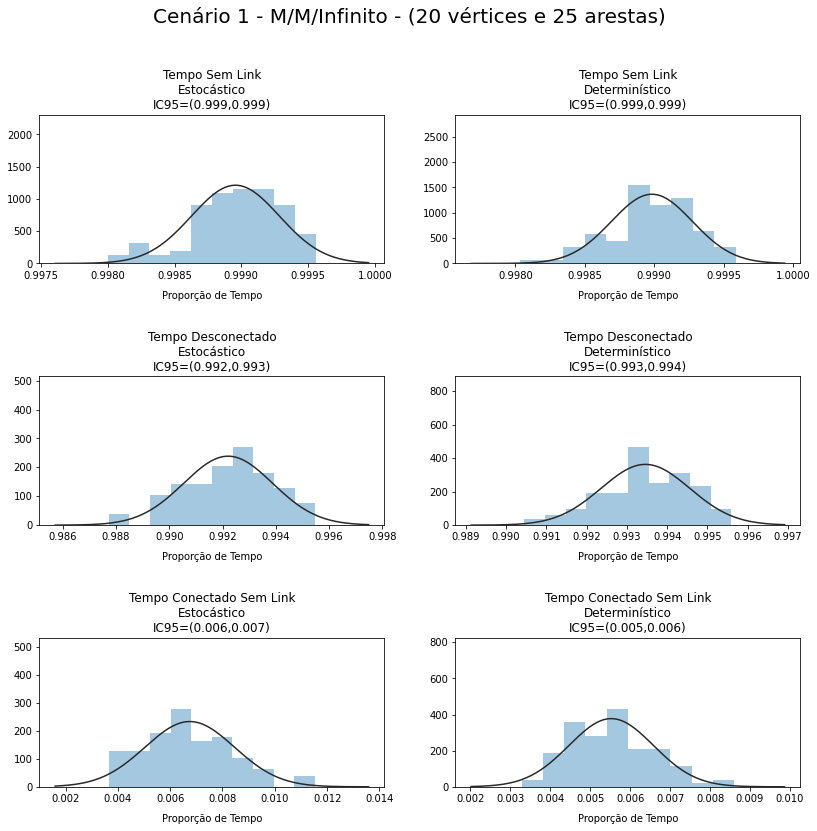

C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(mean - z*(std_dev/math.sqrt(quantity))), np.float(mean + z*(std_dev/math.sqrt(quantity)))
C:\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprec

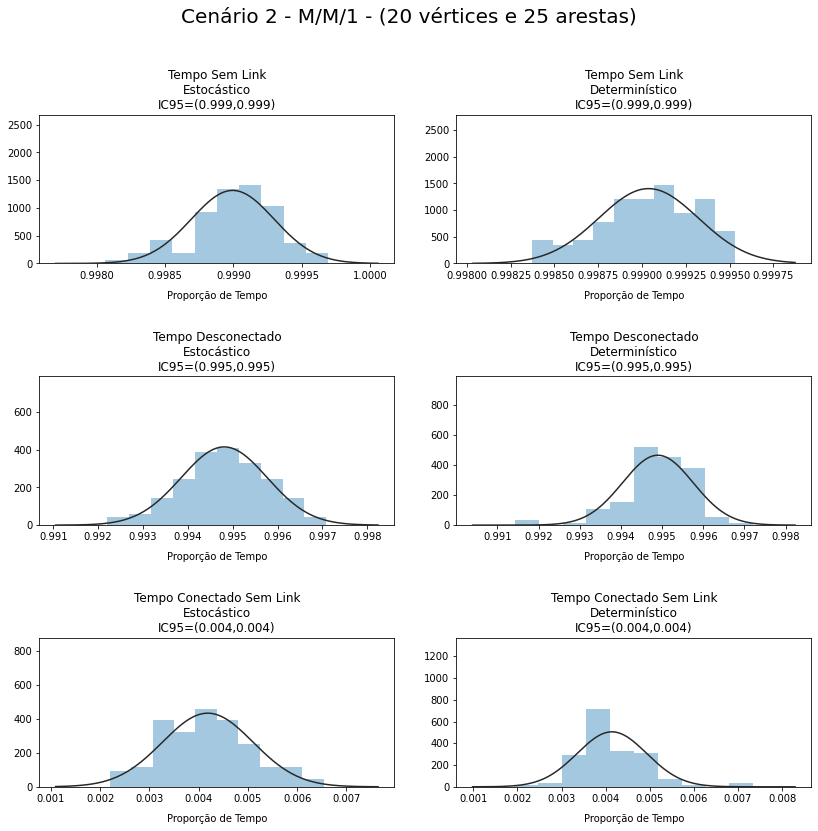

C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(mean - z*(std_dev/math.sqrt(quantity))), np.float(mean + z*(std_dev/math.sqrt(quantity)))
C:\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprec

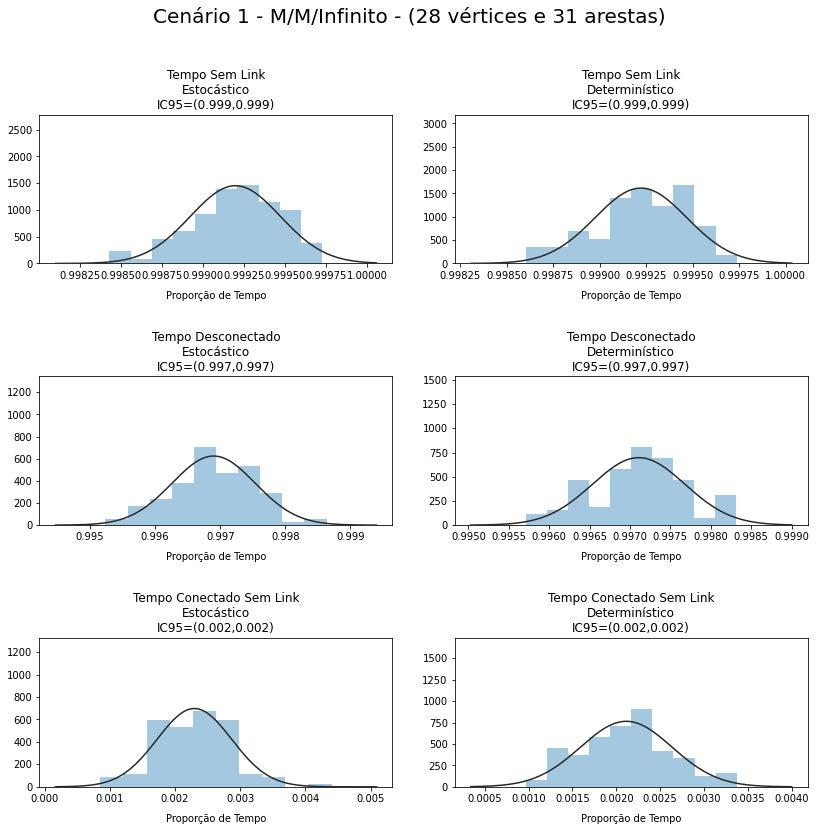

C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(mean - z*(std_dev/math.sqrt(quantity))), np.float(mean + z*(std_dev/math.sqrt(quantity)))
C:\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprec

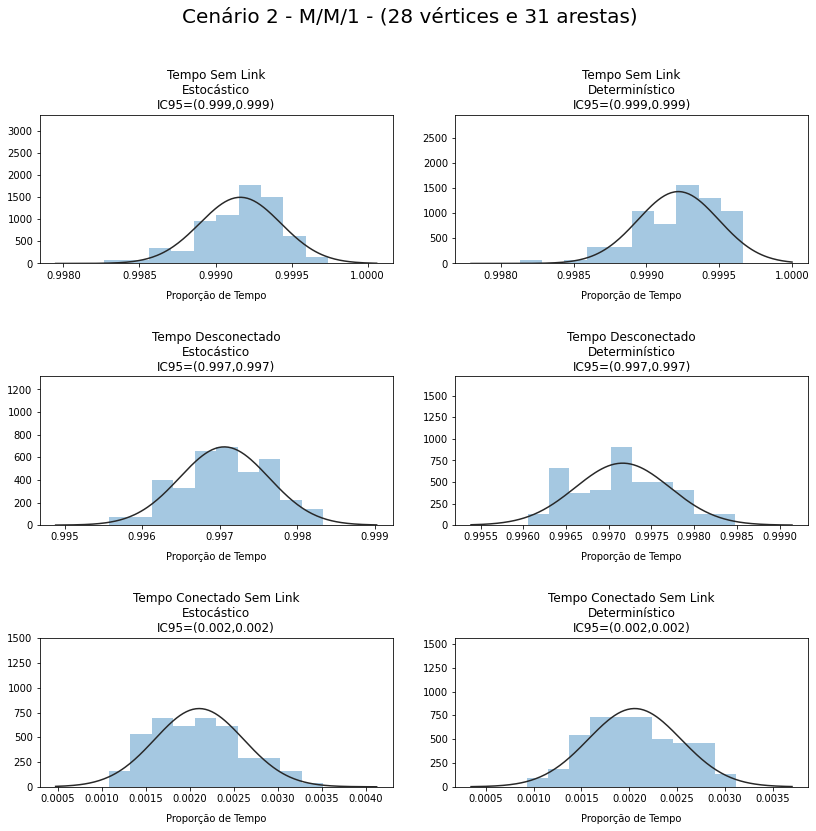

C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(mean - z*(std_dev/math.sqrt(quantity))), np.float(mean + z*(std_dev/math.sqrt(quantity)))
C:\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprec

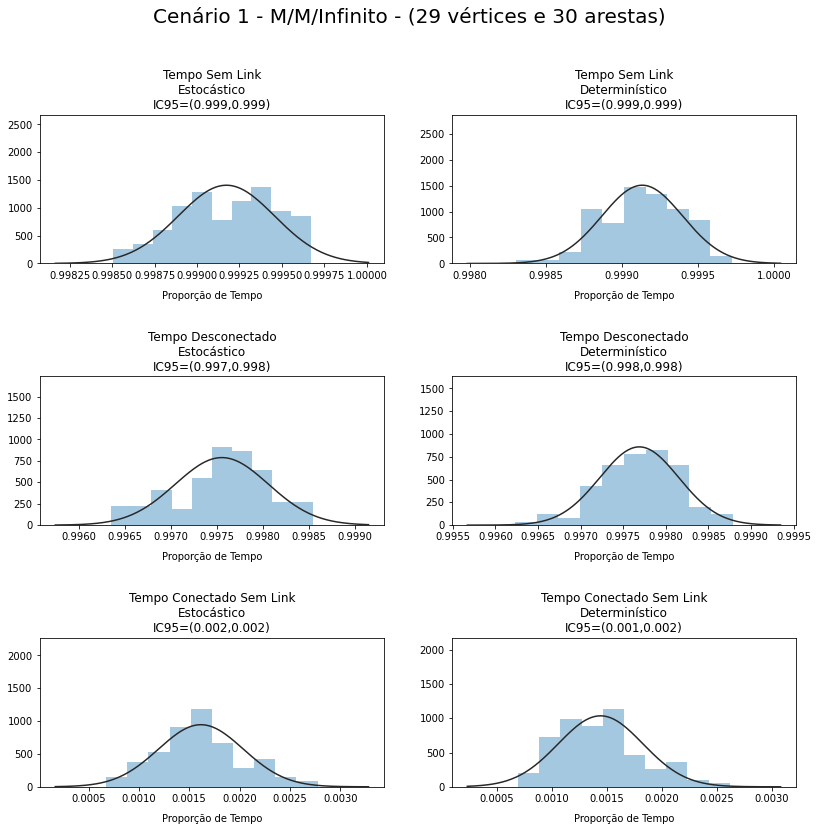

C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(mean - z*(std_dev/math.sqrt(quantity))), np.float(mean + z*(std_dev/math.sqrt(quantity)))
C:\Python38\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\pedro\AppData\Local\Temp/ipykernel_10432/3298415744.py:7: DeprecationWarning: `np.float` is a deprec

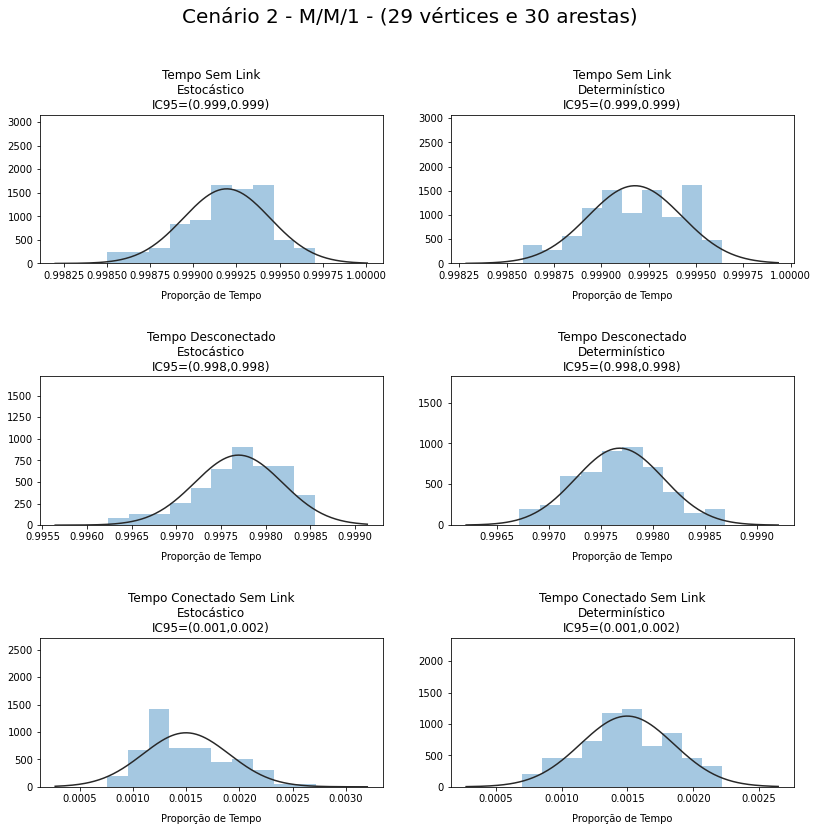

In [108]:
txt_cenario = ['Cenário {} - M/M/Infinito', 'Cenário {} - M/M/1']

for entrada in entradas:
    for i, cenario in enumerate([1,2]):
        salva_figura(txt_cenario[i].format(cenario), resultados_por_round[resultados_por_round.entrada==entrada], cenario, entrada[0], entrada[1])

### Cenário 1

In [49]:
%%capture
for entrada in entradas:
    for value in ['tempo_desconectado','tempo_sem_link','tempo_conectado_sem_link']:
        v,a = entrada
        tmp = resultados_por_round.copy()
        deterministico = tmp[(tmp.cenario == 'SimulacaoCenario1Deterministico') & (tmp.entrada == entrada)][value]
        estocastico = tmp[(tmp.cenario == 'SimulacaoCenario1') & (tmp.entrada == entrada)][value]

        salva_figura(f"C1 - {value}", estocastico, deterministico, v, a)

### Cenário 2

In [50]:
%%capture
for entrada in entradas:
    for value in ['tempo_desconectado','tempo_sem_link','tempo_conectado_sem_link']:
        v,a = entrada
        tmp = resultados_por_round.copy()
        deterministico = tmp[(tmp.cenario == 'SimulacaoCenario2Deterministico') & (tmp.entrada == entrada)][value]
        estocastico = tmp[(tmp.cenario == 'SimulacaoCenario2') & (tmp.entrada == entrada)][value]

        salva_figura(f"C2 - {value}", estocastico, deterministico, v, a)